# Deep Fake Detection. ResNext50

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models
import torchvision.transforms as transforms

from torch.optim import lr_scheduler

from torch.utils.data import random_split, DataLoader
from dataset_handlers.feature_dataset import FeatureDataset

import os
from PIL import Image
from matplotlib import pyplot as plt

ResNeXt (Residual Networks with Exponential Number of Transformations) es una arquitectura de red neuronal convolucional que mejora la capacidad de aprendizaje profundo al introducir bloques residuales con múltiples vías de transformación. Cada vía realiza una transformación mediante una función que involucra la aplicación de un filtro convolucional, normalización por lotes y activación ReLU. La salida total del bloque cardinal es la suma de estas transformaciones. La arquitectura general de ResNeXt se construye apilando bloques residuales, ajustando la profundidad y la anchura según sea necesario, y obteniendo la salida final mediante capas completamente conectadas o de agrupación global.

La función de pérdida comúnmente utilizada es la entropía cruzada, definida como $\text{Entropía Cruzada}(y, p) = -\sum_{i} y_i \log(p_i)$, donde $y$ representa la etiqueta verdadera y $p$ es la predicción de la red. Para más información sobre ña arquitectura, el artículo original se puede encontrar en [https://arxiv.org/abs/1611.0543](https://arxiv.org/abs/1611.05431).

Lo primero que haremos será importar el modelo:

In [2]:
res_next50 = models.resnext50_32x4d(weights='ResNeXt50_32X4D_Weights.IMAGENET1K_V1')

# Transfer Learning

Propondremos dos vías de desarrollo para este problema. En esta primera sección, utilizaremos el modelo ResNeXt-50 pre-entrenado en ImageNet y aplicaremos transfer learning para adaptarlo a nuestro problema, únicamente reentreando las capas fully connected de la red. Para ello, hemos previemante generado un dataset con las imagenes originales procesadas por el modelo ResNeXt-50 hasta su último bloque residual. Hecho esto, tan solo nos quedaría definir un modelo lineal que se ajuste a estos datos. Proponemos la siguiente alternativa:

In [3]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(2048, 1024),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 2)
)

Para el entrenamiento, definimos un número de épocas, un factor de regualrización para L1 tanto para L2 y el número de folds en que dividiremos nuestro conjunto de entrenamiento para realizar validación cruzada. Utilizaremos la función de pérdida entropía cruzada y el optimizador AdamW con una tasa de aprendizaje de 0.001. Para la validación, utilizaremos la métrica accuracy.

In [4]:
num_epochs = 20

l1_factor = 0.0001
l2_factor = 0.001

k_folds = 1

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=l2_factor)

Comenzamos así el proceso de entrenamiento

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
def accuracy(model, data_loader, transform):
    acc = 0
    for i, (image, label) in enumerate(data_loader, 1):
        image = image.to(device)
        label = label.to(device)

        image = transform(image)

        output = model(image).reshape(-1, 2)
        acc += (torch.argmax(output, dim=1) == label).sum().item()

    return acc / len(data_loader.dataset)

In [8]:
def train_model(model, transform, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader):
    for epoch in range(num_epochs):
        for i, (image, label) in enumerate(train_loader, 1):
            image = image.to(device)
            label = label.to(device)

            image = transform(image)

            output = model(image).reshape(-1, 2)

            loss = criterion(output, label)

            l1_regularization = torch.tensor(0., requires_grad=False)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)

            l1_regularization.requires_grad_(True)
            loss += l1_factor * l1_regularization

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                acc_training_set.append(accuracy(model, train_loader, transform))
                acc_val_set.append(accuracy(model, val_loader, transform))

                print('Epoch: {}/{}, Batch: {}, Loss: {:.6f}, Acc (train): {:.6f}, Acc (val): {:.6f}'
                      .format(epoch+1, num_epochs, i, loss.item(), acc_training_set[-1], acc_val_set[-1]))

In [9]:
def transform_identity(image):
    return image

In [113]:
acc_training_set = []
acc_val_set = []

for fold in range(k_folds):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/splitted/train_resnext_massive_data_augmentation/train_{fold}/")
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    test_dataset = FeatureDataset(f"data/splitted/test_resnext_massive/test/")
    val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    train_model(model, transform_identity, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch: 1/20, Batch: 10, Loss: 3.749050, Acc (train): 0.607908, Acc (val): 0.530562
Epoch: 1/20, Batch: 20, Loss: 3.722169, Acc (train): 0.566582, Acc (val): 0.533007
Epoch: 1/20, Batch: 30, Loss: 3.582872, Acc (train): 0.607653, Acc (val): 0.530562
Epoch: 1/20, Batch: 40, Loss: 3.586589, Acc (train): 0.594133, Acc (val): 0.523227
Epoch: 1/20, Batch: 50, Loss: 3.506769, Acc (train): 0.600255, Acc (val): 0.530562
Epoch: 1/20, Batch: 60, Loss: 3.404829, Acc (train): 0.607908, Acc (val): 0.530562
Epoch: 2/20, Batch: 10, Loss: 3.308242, Acc (train): 0.588010, Acc (val): 0.540342
Epoch: 2/20, Batch: 20, Loss: 3.239431, Acc (train): 0.603571, Acc (val): 0.518337
Epoch: 2/20, Batch: 30, Loss: 3.198999, Acc (train): 0.607908, Acc (val): 0.530562
Epoch: 2/20, Batch: 40, Loss: 3.096226, Acc (train): 0.605102, Acc (val): 0.528117
Epoch: 2/20, Batch: 50, Loss: 3.037640, Acc (train): 0.607653, Acc (val): 0.530562
Epoch: 2/20, Batch: 60, Loss: 2.953864, Acc (train): 0.6058

Tras no obtener ninguna mejora, detenemos el entrenamiento. Se ha obtenido un accuracy del 53%. A continuación, mostramos la matriz de confusión obtenida:

In [13]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

test_dataset = FeatureDataset(f"data/splitted/test_resnext_massive/test/")
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

for i, (image, label) in enumerate(test_loader, 1):
    image = image.to(device)
    label = label.to(device)

    output = model(image).reshape(-1, 2)
    y_pred.extend(torch.argmax(output, dim=1).tolist())
    y_true.extend(label.tolist())

cm = confusion_matrix(y_true, y_pred)
print(cm)

[[125  67]
 [140  77]]


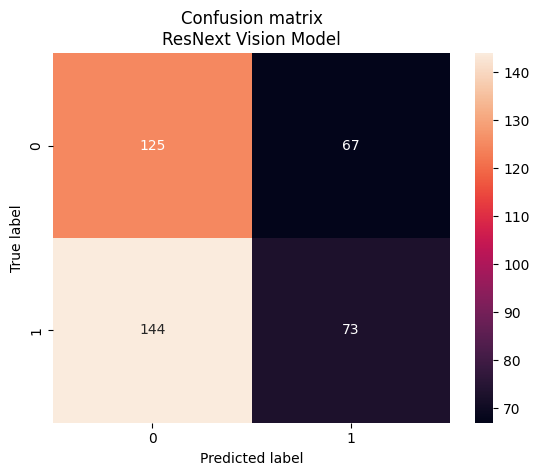
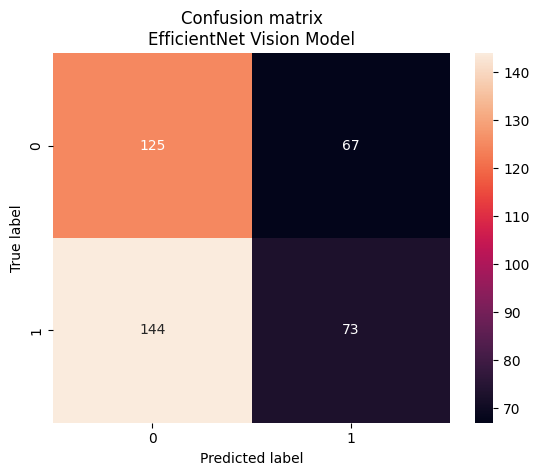
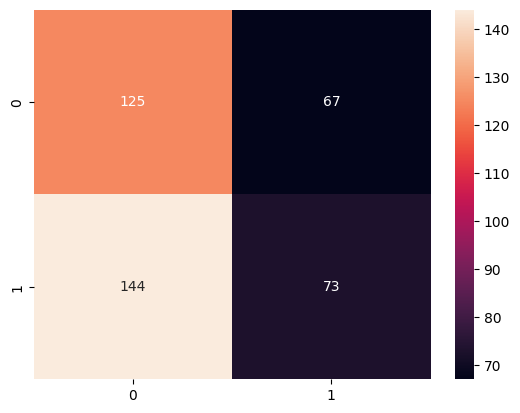

### Imágenes 400x400

Probamos, acontinuación, a entrenar el modelo con imágenes de tamaño **128x128**, en vez de las de tamaño **224x224** que hemos utilizado hasta ahora. El dataset de características ya ha sido creado y guardado, por lo que podemos pasar directamente a definir el modelo con las capas necesarias y entrenarlo. El modelo será igual que el que hemos definido anteriormente, pero ajustando los parámetros de entrada y salida de las capas fully connected.

In [14]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(640000, 2)
)

Definimos un número de épocas, los factores de regualrización y el número de folds. Utilizaremos la función de pérdida entropía cruzada y el optimizador Adam con una tasa de aprendizaje de 0.001. Para la validación, utilizaremos la métrica accuracy.

In [15]:
num_epochs = 10
l1_factor = 0.0001
l2_factor = 0.01

k_folds = 1

La función de pérdida a utilizar será también una entropía cruzada, y el optimizador será Adam, con un learning rate de 0.0001.

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_factor)

num_epochs = 10

In [17]:
acc_training_set = []
acc_val_set = []

for fold in range(k_folds):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/splitted/train_resnext_400_massive_data_augmentation/train_{fold}/")
    train_loader = DataLoader(dataset, batch_size=120, shuffle=True)

    test_dataset = FeatureDataset(f"data/splitted/test_resnext_400_massive/test/")
    val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    train_model(model, transform_identity, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch: 1/10, Batch: 10, Loss: 0.737463, Acc (train): 0.739583, Acc (val): 0.584352
Epoch: 2/10, Batch: 10, Loss: 0.563059, Acc (train): 0.814338, Acc (val): 0.594132
Epoch: 3/10, Batch: 10, Loss: 0.412911, Acc (train): 0.963848, Acc (val): 0.657702
Epoch: 4/10, Batch: 10, Loss: 0.318640, Acc (train): 0.991422, Acc (val): 0.652812
Epoch: 5/10, Batch: 10, Loss: 0.316293, Acc (train): 0.996936, Acc (val): 0.645477
Epoch: 6/10, Batch: 10, Loss: 0.261781, Acc (train): 1.000000, Acc (val): 0.650367
Epoch: 7/10, Batch: 10, Loss: 0.221533, Acc (train): 1.000000, Acc (val): 0.643032
Epoch: 8/10, Batch: 10, Loss: 0.233809, Acc (train): 1.000000, Acc (val): 0.674817
Epoch: 9/10, Batch: 10, Loss: 0.206796, Acc (train): 1.000000, Acc (val): 0.677262
Epoch: 10/10, Batch: 10, Loss: 0.191611, Acc (train): 1.000000, Acc (val): 0.652812


En comparación con el modelo anterior, este modelo si es capaz de entrenar y obtener un 67% de accuracy en test. No obstante, sigue sufriendo de sobre ajuste.

### ¿Y si aplicaramos cross-validation?

Aplicaremos ahora cross validation en su versión más tradicional, como se llegó a hacer para el modelo Vgg16. Para ello, redefinimos el modelo y, tras variar ligeramente los hiperparámetros, entrenamos.

In [29]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.9),
    nn.Linear(640000, 2)
)

In [30]:
num_epochs = 5
l1_factor = 0.001
l2_factor = 0.01

k_folds = 5

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_factor)

In [32]:
acc_training_set = []
acc_val_set = []

for fold in range(k_folds):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/splitted/train_resnext_400_massive_data_augmentation/train_0/")
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=120, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

    train_model(model, transform_identity, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch: 1/5, Batch: 10, Loss: 1.532702, Acc (train): 0.668966, Acc (val): 0.568807
Epoch: 2/5, Batch: 10, Loss: 1.258356, Acc (train): 0.779310, Acc (val): 0.562691
Epoch: 3/5, Batch: 10, Loss: 1.169300, Acc (train): 0.877395, Acc (val): 0.636086
Epoch: 4/5, Batch: 10, Loss: 1.163017, Acc (train): 0.921839, Acc (val): 0.614679
Epoch: 5/5, Batch: 10, Loss: 1.090846, Acc (train): 0.904981, Acc (val): 0.602446
Training model for Fold:  2
Epoch: 1/5, Batch: 10, Loss: 1.100284, Acc (train): 0.895019, Acc (val): 0.840979
Epoch: 2/5, Batch: 10, Loss: 1.045528, Acc (train): 0.904981, Acc (val): 0.837920
Epoch: 3/5, Batch: 10, Loss: 0.984720, Acc (train): 0.954023, Acc (val): 0.828746
Epoch: 4/5, Batch: 10, Loss: 0.952609, Acc (train): 0.933333, Acc (val): 0.825688
Epoch: 5/5, Batch: 10, Loss: 0.924968, Acc (train): 0.959387, Acc (val): 0.767584
Training model for Fold:  3
Epoch: 1/5, Batch: 10, Loss: 0.955286, Acc (train): 0.956322, Acc (val): 0.938838
Epoch: 2/5, Ba

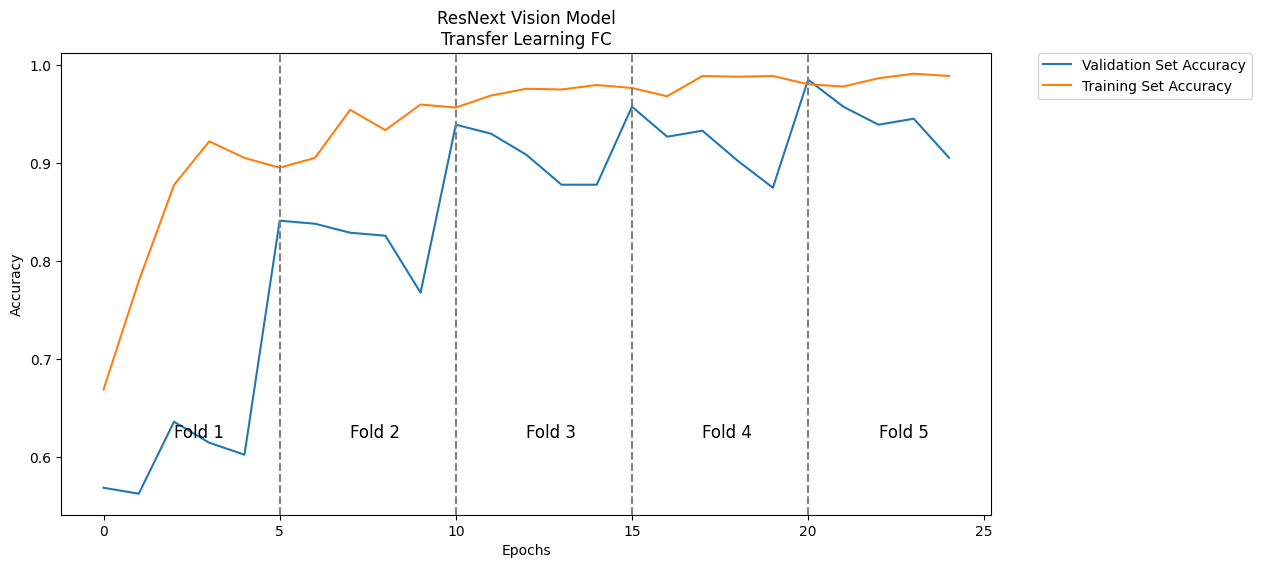
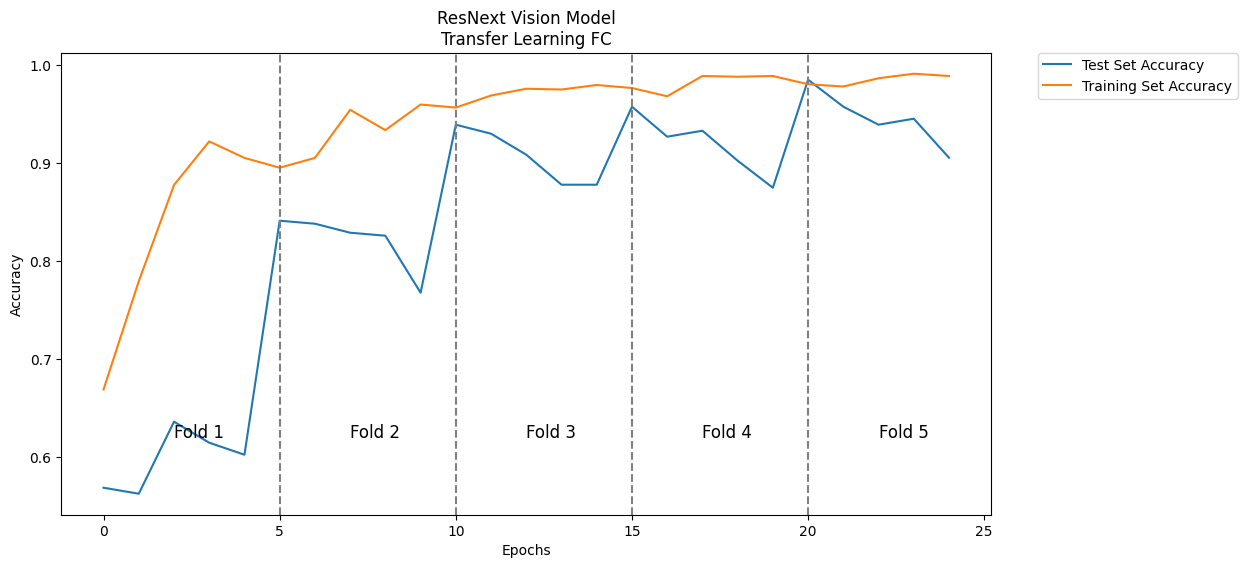

In [33]:
test_dataset = FeatureDataset(f"data/splitted/test_resnext_400_massive/test/")
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

print(accuracy(model, test_loader, transform_identity))

0.6210268948655256


El modelo sigue presentando un gran sobre ajuste.

# Fine Tuning

### Imágenes 224x224

Ahora sí, ante los deficientes resultados del modelo anterior, damos paso al fine tuning. El Fine Tuning consiste en adaptar el modelo pre-entrenado a nuestro problema más en detalle, reentrenando las capas convolutivas más profundas de nuestro modelo, en este caso, la última capa convolutivas. Para ello, hemos previemante generado un dataset con las imagenes originales procesadas por el modelo ResNeXt-50 hasta su penúltimo bloque residual. Hecho esto, tan solo nos quedaría definir un modelo lineal que se ajuste a estos datos. Proponemos la siguiente alternativa:

In [36]:
model = nn.Sequential(
    res_next50.layer4,
    res_next50.avgpool,
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(2048, 2)
)

Definimos un número de épocas, los factores de regualrización y el número de folds. Utilizaremos la función de pérdida entropía cruzada y el optimizador Adam con una tasa de aprendizaje de 0.001. Para la validación, utilizaremos la métrica accuracy.

In [40]:
num_epochs = 10
l1_factor = 0.0001
l2_factor = 0.01

k_folds = 1

La función de pérdida a utilizar será también una entropía cruzada, y el optimizador será Adam, con un learning rate de 0.0001.

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_factor)

num_epochs = 10

In [42]:
def transform_reshape_fc(image):
    return image.reshape(-1, 1024, 14, 14)

In [43]:
acc_training_set = []
acc_val_set = []

for fold in range(k_folds):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/splitted/train_resnext_massive_data_augmentation_ft/train_{fold}/")
    train_loader = DataLoader(dataset, batch_size=3*64, shuffle=True)

    test_dataset = FeatureDataset(f"data/splitted/test_resnext_massive_ft/test/")
    val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    train_model(model, transform_reshape_fc, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch: 1/10, Batch: 10, Loss: 16.788441, Acc (train): 0.731122, Acc (val): 0.599022
Epoch: 1/10, Batch: 20, Loss: 16.096039, Acc (train): 0.851020, Acc (val): 0.667482
Epoch: 2/10, Batch: 10, Loss: 15.073441, Acc (train): 0.944898, Acc (val): 0.674817
Epoch: 2/10, Batch: 20, Loss: 14.422299, Acc (train): 0.992347, Acc (val): 0.640587
Epoch: 3/10, Batch: 10, Loss: 13.652712, Acc (train): 0.997959, Acc (val): 0.650367
Epoch: 3/10, Batch: 20, Loss: 13.074950, Acc (train): 0.999490, Acc (val): 0.655257


No nos hace falta entrenar el modelo durante más épocas para observar que tenemos el mismo problema con el sobre ajuste. Por este motivo, descartamos este modelo y pasamos a probar con imágenes de tamaño 128x128.

### Imágenes 128x128

Probamos, acontinuación, a entrenar el modelo con imágenes de tamaño **128x128**, en vez de las de tamaño **224x224** que hemos utilizado hasta ahora. El dataset de características ya ha sido creado y guardado, por lo que podemos pasar directamente a definir el modelo con las capas necesarias y entrenarlo. El modelo será igual que el que hemos definido anteriormente, pero ajustando los parámetros de entrada y salida de las capas fully connected.

In [23]:
model = nn.Sequential(
    res_next50.layer4,
    res_next50.avgpool,
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(2048, 2)
)

Definimos un número de épocas, los factores de regualrización y el número de folds. Utilizaremos la función de pérdida entropía cruzada y el optimizador Adam con una tasa de aprendizaje de 0.001. Para la validación, utilizaremos la métrica accuracy.

In [24]:
num_epochs = 5
l1_factor = 0.0001
l2_factor = 0.1

k_folds = 1

La función de pérdida a utilizar será también una entropía cruzada, y el optimizador será Adam, con un learning rate de 0.0001.

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=l2_factor)

In [26]:
def transform_reshape_fc(image):
    return image.reshape(-1, 1024, 8, 8)

In [27]:
acc_training_set = []
acc_val_set = []

for fold in range(k_folds):
    print("Training model for Fold: ", fold+1)
    dataset = FeatureDataset(f"data/splitted/train_resnext_128_massive_data_augmentation_ft/train_{fold}/")
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    test_dataset = FeatureDataset(f"data/splitted/test_resnext_128_massive_ft/test/")
    val_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

    train_model(model, transform_reshape_fc, criterion, optimizer, acc_training_set, acc_val_set, l1_factor, train_loader, val_loader)

Training model for Fold:  1
Epoch: 1/5, Batch: 10, Loss: 15.506186, Acc (train): 0.642157, Acc (val): 0.535452
Epoch: 1/5, Batch: 20, Loss: 14.796187, Acc (train): 0.707925, Acc (val): 0.594132
Epoch: 1/5, Batch: 30, Loss: 14.107141, Acc (train): 0.754698, Acc (val): 0.621027
Epoch: 1/5, Batch: 40, Loss: 13.392412, Acc (train): 0.799020, Acc (val): 0.635697
Epoch: 1/5, Batch: 50, Loss: 12.638279, Acc (train): 0.824755, Acc (val): 0.628362
Epoch: 1/5, Batch: 60, Loss: 12.141031, Acc (train): 0.872958, Acc (val): 0.647922
Epoch: 1/5, Batch: 70, Loss: 11.683423, Acc (train): 0.902574, Acc (val): 0.650367
Epoch: 2/5, Batch: 10, Loss: 10.396067, Acc (train): 0.913194, Acc (val): 0.630807
Epoch: 2/5, Batch: 20, Loss: 9.886733, Acc (train): 0.941789, Acc (val): 0.623472
Epoch: 2/5, Batch: 30, Loss: 9.420681, Acc (train): 0.945670, Acc (val): 0.623472
Epoch: 2/5, Batch: 40, Loss: 9.136283, Acc (train): 0.943627, Acc (val): 0.623472
Epoch: 2/5, Batch: 50, Loss: 8.709373, Acc (train): 0.948529, 

Nuevamente, el modelo ha conseguido adaptarse a los datos de entrenamiento, pero no a los de test. El accuracy obtenido es del 66%.